# HOUSE PRICE PREDICTION

## Step 0 : Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Display settings
import warnings
warnings.filterwarnings("ignore")


## Step 1: Load the Dataset and Clean

In [3]:
# Load teh dataset
df = pd.read_csv("data.csv")

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [5]:
# As country is uneccessary , drop the column country
df.drop(columns=['country'], inplace=True)

In [7]:
df.shape

(4600, 17)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
dtypes: float64(4), int64(9), object(4)
memory usage: 611

In [9]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip'],
      dtype='object')

## Step 2 : Convert date column to useful features

Convert the date column to datetime format

Extract the year and month of the sale

Drop the original date column



In [11]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year and month
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month

# Drop the original 'date' column
df.drop(columns=['date'], inplace=True)

# Check the updated columns
print(df[['year_sold', 'month_sold']].head())


   year_sold  month_sold
0       2014           5
1       2014           5
2       2014           5
3       2014           5
4       2014           5


## Step 3: Remove Outliers (Price = 0 or Extremely High)

In [12]:
# Remove rows with price = 0
df = df[df['price'] > 0]

# Optionally, remove top 1% outlier prices
q99 = df['price'].quantile(0.99)
df = df[df['price'] < q99]

# Check new shape and price range
print("Shape after outlier removal:", df.shape)
print("Price range:", df['price'].min(), "to", df['price'].max())


Shape after outlier removal: (4505, 18)
Price range: 7800.0 to 2005000.0


## Step 4: Drop street, and Split statezip into state and zipcode

street has high cardinality and won’t help the model ➜ Drop it.

statezip includes both state and zip code (e.g., "WA 98133") ➜ Let’s split it into:

state (e.g., WA)

zipcode (e.g., 98133)

In [13]:
# Drop the 'street' column (high-cardinality text feature)
df.drop(columns=['street'], inplace=True)

# Split 'statezip' into 'state' and 'zipcode'
df[['state', 'zipcode']] = df['statezip'].str.split(' ', expand=True)
df.drop(columns=['statezip'], inplace=True)

# View sample of new columns
print(df[['state', 'zipcode']].head())


  state zipcode
0    WA   98133
2    WA   98042
3    WA   98008
4    WA   98052
5    WA   98115


## Step 5: Quick Exploratory Data Analysis (EDA)

Understanding relationships with price

Spotting skewed features

Checking categorical distributions

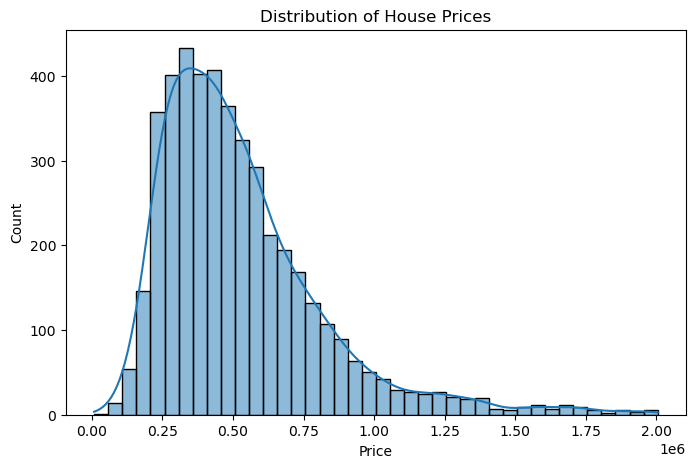

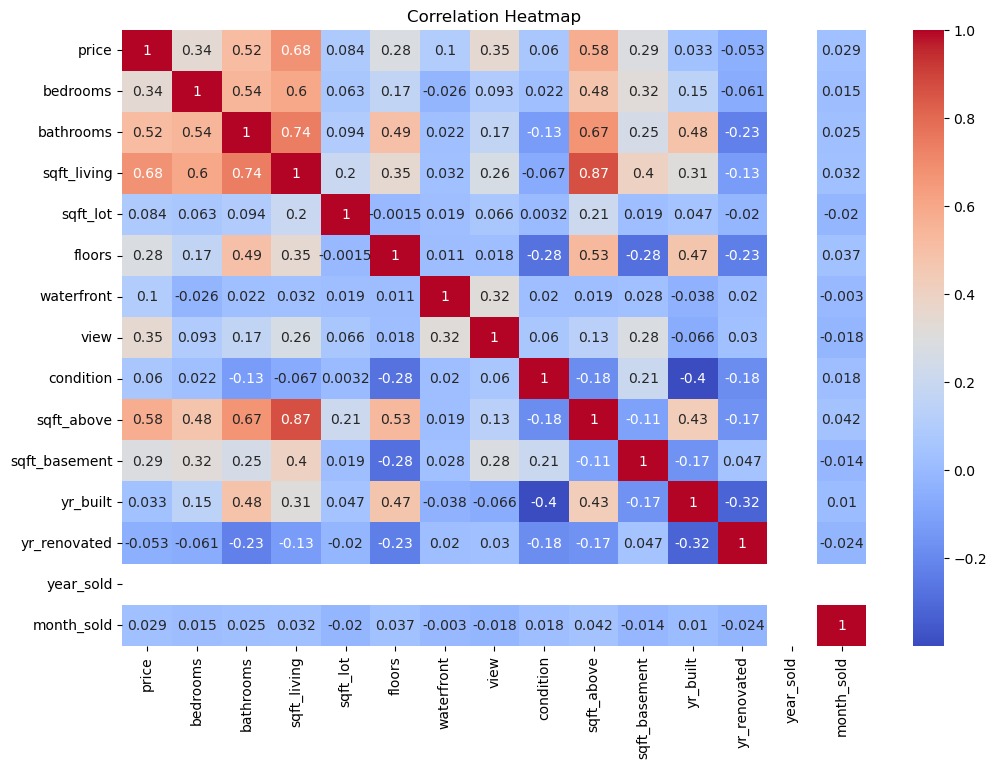

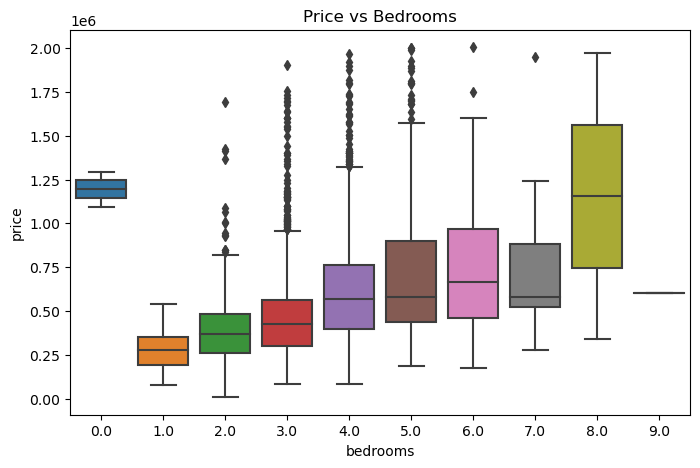

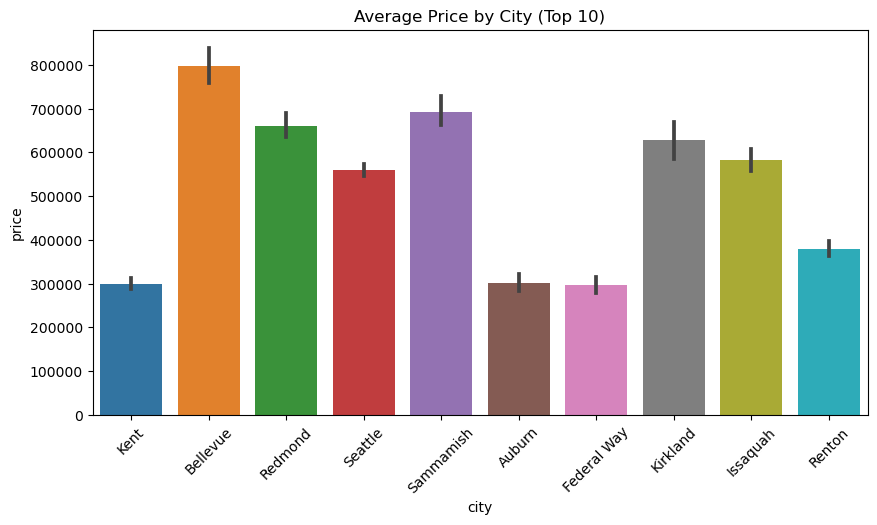

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=40, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# 2. Correlation heatmap (numerical features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 3. Bedrooms vs Price (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Price vs Bedrooms')
plt.show()

# 4. City vs Average Price (Top 10 cities only)
top_cities = df['city'].value_counts().head(10).index
plt.figure(figsize=(10, 5))
sns.barplot(x='city', y='price', data=df[df['city'].isin(top_cities)], estimator=np.mean)
plt.title('Average Price by City (Top 10)')
plt.xticks(rotation=45)
plt.show()


###  **1. Price Distribution Plot**

####  Observation:

* Skewed to the **right** (positive skew).
* Most houses are priced under **\$750,000**, with a long tail up to \~\$2M.
* There’s a sharp peak around **\$300K–\$400K**.

#### How it's useful:

* We may consider **log-transforming** the `price` to reduce skew and improve model performance later.
* Outlier handling (done already) was justified — high-end prices are rare.

---

###  **2. Correlation Heatmap**

####  Observation:

* Top features correlated with `price`:

  * `sqft_living` (**0.68**)
  * `bathrooms` (**0.52**)
  * `sqft_above`, `bedrooms`, `view`, `sqft_basement`
* Weak or no correlation:

  * `yr_built`, `floors`, `zipcode`, `month_sold`, `condition`

####  How it's useful:

* We’ll prioritize high-correlation features.
* May drop or regularize low-correlation features to avoid noise.

---

###  **3. Price vs Bedrooms (Boxplot)**


####  Observation:

* **No strict linear trend** between bedrooms and price.
* Houses with 0–1 bedrooms have **surprisingly high prices** — likely **luxury apartments or noise**.
* 3–5 bedrooms seem most common with wide price range.

####  How it's useful:

* Treat `bedrooms` with caution — not always predictive.
* Consider grouping rare bedroom counts (e.g., 0, 8, 9) into "Other" later.

---

###  **4. Average Price by City (Top 10)**


####  Observation:

* **Bellevue**, **Sammamish**, and **Redmond** are high-priced cities.
* **Kent**, **Auburn**, and **Federal Way** have lower average prices.
* City definitely impacts pricing!

####  How it's useful:

* **City** should be encoded (e.g., one-hot or target encoding).
* We could also try **mean price encoding** for better modeling.

---

## Step 6: Feature Selection, Encoding & Train-Test Split

In [15]:
# 1. Drop non-useful columns
df.drop(columns=['state', 'zipcode'], inplace=True)

# 2. Define target and features
X = df.drop(columns=['price'])  # Features
y = df['price']                 # Target

# 3. Identify column types
categorical_cols = ['city']  # Only city needs encoding
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (3604, 15)
Test shape: (901, 15)


In [16]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,year_sold,month_sold
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,2014,5
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,2014,5
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,2014,5
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,2014,5
5,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,Seattle,2014,5


## Step 7: Build Preprocessing + Linear Regression Pipeline

Scale all numerical columns using StandardScaler

Encode categorical column (city) using OneHotEncoder

Use ColumnTransformer to combine them

Train a Linear Regression model using a clean pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

# 1. Preprocessor for columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# 2. Full pipeline with Linear Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 3. Train the model
model_pipeline.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = model_pipeline.predict(X_test)

# 5. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Evaluation:")
print(f"R2 Score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Linear Regression Evaluation:
R2 Score: 0.7018207215812144
RMSE: 152411.9195833321
MAE: 101226.6485640746


## Step 8: Random Forest Regressor with Preprocessing Pipeline

Use the same ColumnTransformer (scaling + encoding)

Replace LinearRegression() with RandomForestRegressor()

Train and evaluate the model

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Create new pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Evaluation:")
print(f"R2 Score: {r2_rf}")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")


Random Forest Evaluation:
R2 Score: 0.6721594840169931
RMSE: 159812.7833952759
MAE: 102131.96715615576


## Step 9: XGBoost Regressor with Preprocessing Pipeline

Use the same ColumnTransformer for preprocessing

Use XGBRegressor inside a pipeline

Evaluate performance on test data

In [35]:
from xgboost import XGBRegressor

# Create pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.09,
        max_depth=6,
        random_state=42,
        verbosity=0
    ))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Evaluation:")
print(f"R2 Score: {r2_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")


XGBoost Evaluation:
R2 Score: 0.6945330318284553
RMSE: 154263.19801650473
MAE: 98222.35755224751


## Step 10: Hyperparameter Tuning (GridSearchCV on XGBoost)

In [36]:
from sklearn.model_selection import GridSearchCV

# XGBoost model (without pipeline for tuning)
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Create GridSearch with preprocessing pipeline
grid_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Grid search
grid_search = GridSearchCV(
    estimator=grid_pipeline,
    param_grid={'regressor__' + key: val for key, val in param_grid.items()},
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Metrics
print("Best Parameters:", grid_search.best_params_)
print("Tuned XGBoost Evaluation:")
print("R2 Score:", r2_score(y_test, y_pred_best))
print("RMSE:", mean_squared_error(y_test, y_pred_best, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_best))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Tuned XGBoost Evaluation:
R2 Score: 0.6888418745496816
RMSE: 155693.60565450808
MAE: 98974.39422355716


## Step 11: Plot Top Feature Importances from XGBoost

<Figure size 1000x600 with 0 Axes>

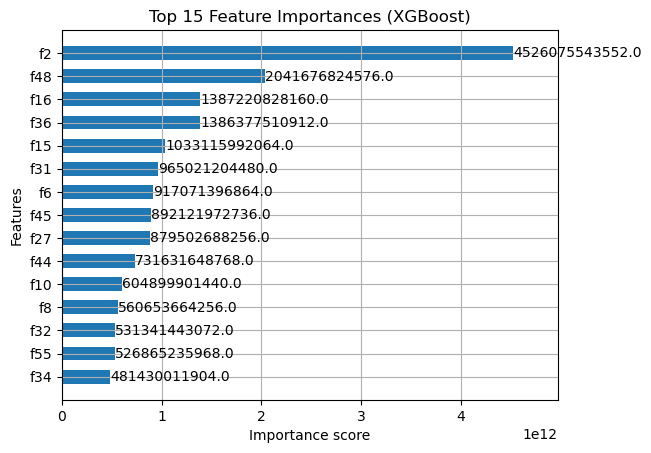

In [37]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Get the XGBoost model from the pipeline
xgb_best = best_model.named_steps['regressor']

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()


Each bar (f2, f48, etc.) represents a feature used by XGBoost after preprocessing.

These labels like f2, f48 are internal feature indices assigned after encoding (e.g. OneHotEncoder for city, and scaling for numerical columns).

The longer the bar = the more important that feature was for making decisions in the model.

## Step 12: Save the Final Trained XGBoost Model Pipeline

In [38]:
import joblib

# Save the best model pipeline
joblib.dump(best_model, 'final_xgboost_model.pkl')

print(" Model saved as 'final_xgboost_model.pkl'")


 Model saved as 'final_xgboost_model.pkl'


##  Step 13 Code: Load & Predict

In [39]:
import joblib
import pandas as pd

# Load the saved model
loaded_model = joblib.load('final_xgboost_model.pkl')

# Example: Predict on new/unseen data (use same structure as training features)
# Suppose you want to predict for 5 rows from test set
sample = X_test.iloc[:5]

# Predict
predicted_prices = loaded_model.predict(sample)

# Show predictions
print("Predicted Prices:", predicted_prices)


Predicted Prices: [495406.94 317170.75 302717.3  646745.56 444833.12]
